### Load Json Files ###

In [ ]:
import json
import os

def load_json_file(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            data = json.load(file)
            print(f"JSON data successfully loaded from {file_path}")
            return data
    except FileNotFoundError:
        print(f"The file {file_path} was not found.")
    except json.JSONDecodeError:
        print(f"Error decoding JSON from the file {file_path}.")
    except Exception as e:
        print(f"An error occurred while reading {file_path}: {e}")
    return None

def merge_dictionaries(base_dict, new_dict):
    for key, value in new_dict.items():
        if key in base_dict:
            if isinstance(base_dict[key], dict) and isinstance(value, dict):
                merge_dictionaries(base_dict[key], value)
            elif isinstance(base_dict[key], list) and isinstance(value, list):
                base_dict[key].extend(value)
            else:
                base_dict[key] = value  # Overwrite the value
        else:
            base_dict[key] = value

def load_multiple_json_files(directory):
    json_files = [f for f in os.listdir(directory) if f.endswith('.json')]
    combined_data = {}

    for json_file in json_files:
        file_path = os.path.join(directory, json_file)
        data = load_json_file(file_path)
        if data is not None:
            if isinstance(data, dict):
                merge_dictionaries(combined_data, data)

    return combined_data

directory = 'D:/Gastrodataset/MergedAnnotations/MergedAnnotations'
all_json_data = load_multiple_json_files(directory)
print(f"Total number of keys in the merged dictionary: {len(all_json_data)}")

with open('combined_data.json', 'w', encoding='utf-8') as f:
    json.dump(all_json_data, f, ensure_ascii=False, indent=4)

print(all_json_data)


### Logic for Categorized Word Comparison

1. **Prepare Word Categories**:
   - Define lists of words for each category (e.g., numbers, colors, anatomical terms).

2. **Lemmatization**:
   - Lemmatize the category words to ensure consistency during comparisons.
   - Lemmatize the text from the JSON data (both original and corrected versions).

3. **Mistake Identification**:
   - For each word in the original text:
     - If the word belongs to a category and is missing in the corrected text, count it as a mistake.
     - Assign the mistake to the correct category.

4. **Result Output**:
   - Return a count of mistakes for each category.


In [ ]:
import json
import spacy

# Load spaCy's pre-trained model
nlp = spacy.load("en_core_web_sm")

# Predefined word categories
raw_category_words = {
    "number_words": {
        "no", "none", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine", "ten",
        "eleven", "twelve", "thirteen", "fourteen", "fifteen", "sixteen", "seventeen", "eighteen",
        "nineteen", "twenty", "thirty", "forty", "fifty", "sixty", "seventy", "eighty", "ninety",
        "hundred", "thousand", "million", "billion", "first", "second", "third", "last", "all"
    },
    "medical_findings": {
        "inflammation", "swelling", "redness", "pain", "irritation", "sore", "tenderness",
        "bleeding", "hemorrhage", "bruise", "hematoma", "blood", "ecchymosis", "blood loss",
        "foreign body", "object", "implant", "foreign object", "foreign substance", "foreign matter", "instrument",
        "infection", "infected", "septic", "abscess", "bacteremia", "virus", "viral", "bacteria", "microbial", "fungus",
        "fever", "chills", "nausea", "vomiting", "cough", "headache", "dizziness", "fatigue", "malaise", "weakness",
        "discharge", "rash", "pain", "itching", "congestion", "swelling", "anatomical", "landmarks", "abnormality"
    },
    "location_words": {
        "right", "left", "upper", "down", "center", "middle", "top", "bottom", "north", "south",
        "east", "west", "front", "back", "above", "below", "inside", "outside", "near", "far", "centre"
    },
    "anatomical_class_terms": {
        "cecum", "pylorus", "z-line"
    },
    "color_words": {
        "red", "blue", "green", "yellow", "black", "white", "purple", "orange", "brown", "pink",
        "gray", "violet", "indigo", "beige", "teal", "cyan", "magenta", "maroon", "navy", "gold",
        "silver", "amber", "turquoise", "lime", "coral", "peach", "ivory", "charcoal", "lavender", "light", "dark"
    }
}

# Function to lemmatize category words
def lemmatize_category_words(category_words):
    lemmatized_words = set()
    for word in category_words:
        doc = nlp(word)
        lemmatized_words.add(doc[0].lemma_)
    return lemmatized_words

# Lemmatize all category words
number_words = lemmatize_category_words(raw_category_words["number_words"])
medical_findings = lemmatize_category_words(raw_category_words["medical_findings"])
location_words = lemmatize_category_words(raw_category_words["location_words"])
anatomical_class_terms = lemmatize_category_words(raw_category_words["anatomical_class_terms"])
color_words = lemmatize_category_words(raw_category_words["color_words"])

# Function to detect category words in the text
def detect_category_words(text, category_words):
    doc = nlp(text)
    detected_words = set()
    for token in doc:
        if token.lemma_.lower() in category_words:
            detected_words.add(token.lemma_.lower())
    return detected_words

# Function to compare original and corrected text
def compare_texts(original_text, correction_text):
    # Detect words in both texts for each category
    detected_original = {
        "numbers": detect_category_words(original_text, number_words),
        "medical_findings": detect_category_words(original_text, medical_findings),
        "locations": detect_category_words(original_text, location_words),
        "anatomical_class": detect_category_words(original_text, anatomical_class_terms),
        "colors": detect_category_words(original_text, color_words)
    }
    
    detected_corrected = {
        "numbers": detect_category_words(correction_text, number_words),
        "medical_findings": detect_category_words(correction_text, medical_findings),
        "locations": detect_category_words(correction_text, location_words),
        "anatomical_class": detect_category_words(correction_text, anatomical_class_terms),
        "colors": detect_category_words(correction_text, color_words)
    }
    
    # Calculate the number of common and missing words in each category
    comparison_result = {}
    for category in detected_original:
        
        # present in original but not in corrected
        missing_in_correction = detected_original[category] - detected_corrected[category]
        
        comparison_result[category] = len(missing_in_correction)

    return comparison_result

# Function to process the JSON file and generate results
def analyze_changes(json_data):
    changes_per_image = {}

    for image_id, data in json_data.items():
        original_text = data["original_text"]
        correction_text = data["corrections"]
        
        comparison = compare_texts(original_text, correction_text)
        changes_per_image[image_id] = comparison
    
    return changes_per_image


# Run analysis
results = analyze_changes(all_json_data)
print(json.dumps(results, indent=4))


In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Data preparation for histogram
categories = ["numbers", "medical_findings", "locations", "anatomical_class", "colors"]
counts = {category: 0 for category in categories}


# Aggregate counts from each image
for result in results.values():
    for category, count in result.items():
        counts[category] += count

# Configure global font size
mpl.rcParams['font.size'] = 14  # Adjusts the base font size for all text elements

# Plotting the histogram
plt.figure(figsize=(10, 5))
plt.bar(counts.keys(), counts.values(), color='skyblue')
plt.xlabel('Categories')
plt.ylabel('Count of missing words')
plt.xticks(fontsize=12)  # Adjust font size for x-axis labels

# Set y-ticks to show natural numbers with an appropriate step size
max_count = max(counts.values())
step_size = max(1, max_count // 10)  # Calculate step size based on the max count
plt.yticks(range(0, max_count + 1, step_size))

plt.show()


### Logic for Categorized Word Comparison

1. **Prepare Word Categories**:
   - Define lists of words for each category (e.g., numbers, colors, anatomical terms).

2. **Check Annotations**:
   - Access the `annotations` field in the JSON data.
   - For entries where `type == 'incorrect'`:
     - Extract the corresponding `text` and check if it contains words from each category list.
     - Lemmatize both the category words and the text before checking for matches.
     - *If multiple words in the text belong to the same category, count each occurrence.*

4. **Result Output**:
   - Return a count of mistakes for each category.


In [ ]:
import json
import spacy

# Load spaCy's pre-trained model
nlp = spacy.load("en_core_web_sm")

# Predefined word categories
raw_category_words = {
    "number_words": {
        "no", "none", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine", "ten",
        "eleven", "twelve", "thirteen", "fourteen", "fifteen", "sixteen", "seventeen", "eighteen",
        "nineteen", "twenty", "thirty", "forty", "fifty", "sixty", "seventy", "eighty", "ninety",
        "hundred", "thousand", "million", "billion", "first", "second", "third", "last", "all"
    },
    "medical_findings": {
        "inflammation", "swelling", "redness", "pain", "irritation", "sore", "tenderness",
        "bleeding", "hemorrhage", "bruise", "hematoma", "blood", "ecchymosis", "blood loss",
        "foreign body", "object", "implant", "foreign object", "foreign substance", "foreign matter", "instrument",
        "infection", "infected", "septic", "abscess", "bacteremia", "virus", "viral", "bacteria", "microbial", "fungus",
        "fever", "chills", "nausea", "vomiting", "cough", "headache", "dizziness", "fatigue", "malaise", "weakness",
        "discharge", "rash", "pain", "itching", "congestion", "swelling", "anatomical", "landmarks", "abnormality"
    },
    "location_words": {
        "right", "left", "upper", "down", "center", "middle", "top", "bottom", "north", "south",
        "east", "west", "front", "back", "above", "below", "inside", "outside", "near", "far", "centre"
    },
    "anatomical_class_terms": {
        "cecum", "pylorus", "z-line"
    },
    "color_words": {
        "red", "blue", "green", "yellow", "black", "white", "purple", "orange", "brown", "pink",
        "gray", "violet", "indigo", "beige", "teal", "cyan", "magenta", "maroon", "navy", "gold",
        "silver", "amber", "turquoise", "lime", "coral", "peach", "ivory", "charcoal", "lavender", "light", "dark"
    }
}

# Function to lemmatize category words
def lemmatize_category_words(category_words):
    lemmatized_words = set()
    for word in category_words:
        doc = nlp(word)
        lemmatized_words.add(doc[0].lemma_)
    return lemmatized_words

# Lemmatize all category words
number_words = lemmatize_category_words(raw_category_words["number_words"])
medical_findings = lemmatize_category_words(raw_category_words["medical_findings"])
location_words = lemmatize_category_words(raw_category_words["location_words"])
anatomical_class_terms = lemmatize_category_words(raw_category_words["anatomical_class_terms"])
color_words = lemmatize_category_words(raw_category_words["color_words"])



# Function to detect category words in the text
def detect_category_words(text, category_words):
    doc = nlp(text)
    detected_words = set()
    for token in doc:
        if token.lemma_.lower() in category_words:
            detected_words.add(token.lemma_.lower())
    return detected_words

# Function to analyze annotations
def analyze_annotations(annotations):
    category_counts = {
        "numbers": 0,
        "medical_findings": 0,
        "locations": 0,
        "anatomical_class": 0,
        "colors": 0
    }

    for annotation_id, details in annotations.items():
        if details['type'] == 'incorrect':
            # Process only the incorrect annotations
            text = details['text']
            category_counts['numbers'] += len(detect_category_words(text, number_words))
            category_counts['medical_findings'] += len(detect_category_words(text, medical_findings))
            category_counts['locations'] += len(detect_category_words(text, location_words))
            category_counts['anatomical_class'] += len(detect_category_words(text, anatomical_class_terms))
            category_counts['colors'] += len(detect_category_words(text, color_words))

    return category_counts

# Function to process the JSON data and generate results
def process_json_data(json_data):
    results = {}
    for image_id, data in json_data.items():
        annotations = data["annotations"]
        results[image_id] = analyze_annotations(annotations)

    return results


    
results = process_json_data(all_json_data)
print(json.dumps(results, indent=4))



In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Data preparation for histogram
categories = ["numbers", "medical_findings", "locations", "anatomical_class", "colors"]
counts = {category: 0 for category in categories}


# Aggregate counts from each image
for result in results.values():
    for category, count in result.items():
        counts[category] += count

# Configure global font size
mpl.rcParams['font.size'] = 14  # Adjusts the base font size for all text elements

# Plotting the histogram
plt.figure(figsize=(10, 5))
plt.bar(counts.keys(), counts.values(), color='skyblue')
plt.xlabel('Categories')
plt.ylabel('Count of missing words')
plt.xticks(fontsize=12)  # Adjust font size for x-axis labels

# Set y-ticks to show natural numbers with an appropriate step size
max_count = max(counts.values())
step_size = max(1, max_count // 10)  # Calculate step size based on the max count
plt.yticks(range(0, max_count + 1, step_size))

plt.show()


### Logic for Categorized Word Comparison

1. **Prepare Word Categories**:
   - Define lists of words for each category (e.g., numbers, colors, anatomical terms).

2. **Check Annotations**:
   - Access the `annotations` field in the JSON data.
   - For entries where `type == 'incorrect'`:
     - Extract the corresponding `text` and check if it contains words from each category list.
     - Lemmatize both the category words and the text before checking for matches.
     - *Even if multiple words in the text belong to the same category, count only once.*

4. **Result Output**:
   - Return a count of mistakes for each category.


In [ ]:
import json
import spacy

# Load spaCy's pre-trained model
nlp = spacy.load("en_core_web_sm")

# Predefined word categories
raw_category_words = {
    "number_words": {
        "no", "none", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine", "ten",
        "eleven", "twelve", "thirteen", "fourteen", "fifteen", "sixteen", "seventeen", "eighteen",
        "nineteen", "twenty", "thirty", "forty", "fifty", "sixty", "seventy", "eighty", "ninety",
        "hundred", "thousand", "million", "billion", "first", "second", "third", "last", "all"
    },
    "medical_findings": {
        "inflammation", "swelling", "redness", "pain", "irritation", "sore", "tenderness",
        "bleeding", "hemorrhage", "bruise", "hematoma", "blood", "ecchymosis", "blood loss",
        "foreign body", "object", "implant", "foreign object", "foreign substance", "foreign matter", "instrument",
        "infection", "infected", "septic", "abscess", "bacteremia", "virus", "viral", "bacteria", "microbial", "fungus",
        "fever", "chills", "nausea", "vomiting", "cough", "headache", "dizziness", "fatigue", "malaise", "weakness",
        "discharge", "rash", "pain", "itching", "congestion", "swelling", "anatomical", "landmarks", "abnormality"
    },
    "location_words": {
        "right", "left", "upper", "down", "center", "middle", "top", "bottom", "north", "south",
        "east", "west", "front", "back", "above", "below", "inside", "outside", "near", "far", "centre"
    },
    "anatomical_class_terms": {
        "cecum", "pylorus", "z-line"
    },
    "color_words": {
        "red", "blue", "green", "yellow", "black", "white", "purple", "orange", "brown", "pink",
        "gray", "violet", "indigo", "beige", "teal", "cyan", "magenta", "maroon", "navy", "gold",
        "silver", "amber", "turquoise", "lime", "coral", "peach", "ivory", "charcoal", "lavender", "light", "dark"
    }
}

# Function to lemmatize category words
def lemmatize_category_words(category_words):
    lemmatized_words = set()
    for word in category_words:
        doc = nlp(word)
        lemmatized_words.add(doc[0].lemma_)
    return lemmatized_words

# Lemmatize all category words
number_words = lemmatize_category_words(raw_category_words["number_words"])
medical_findings = lemmatize_category_words(raw_category_words["medical_findings"])
location_words = lemmatize_category_words(raw_category_words["location_words"])
anatomical_class_terms = lemmatize_category_words(raw_category_words["anatomical_class_terms"])
color_words = lemmatize_category_words(raw_category_words["color_words"])


# Function to detect category words in the text
def detect_category_words(text, category_words):
    doc = nlp(text)
    detected_words = set()
    for token in doc:
        if token.lemma_.lower() in category_words:
            detected_words.add(token.lemma_.lower())
    return detected_words

# Function to analyze annotations
def analyze_annotations(annotations):
    category_counts = {
        "numbers": 0,
        "medical_findings": 0,
        "locations": 0,
        "anatomical_class": 0,
        "colors": 0
    }

    for annotation_id, details in annotations.items():
        if details['type'] == 'incorrect':
            # Process only the incorrect annotations
            text = details['text']
            if detect_category_words(text, number_words):
                category_counts['numbers'] += 1
            if detect_category_words(text, medical_findings):
                category_counts['medical_findings'] += 1
            if detect_category_words(text, location_words):
                category_counts['locations'] += 1
            if detect_category_words(text, anatomical_class_terms):
                category_counts['anatomical_class'] += 1
            if detect_category_words(text, color_words):
                category_counts['colors'] += 1

    return category_counts

# Function to process the JSON data and generate results
def process_json_data(json_data):
    results = {}
    for image_id, data in json_data.items():
        annotations = data["annotations"]
        results[image_id] = analyze_annotations(annotations)

    return results


    
results = process_json_data(all_json_data)
print(json.dumps(results, indent=4))



In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Data preparation for histogram
categories = ["numbers", "medical_findings", "locations", "anatomical_class", "colors"]
counts = {category: 0 for category in categories}


# Aggregate counts from each image
for result in results.values():
    for category, count in result.items():
        counts[category] += count

# Configure global font size
mpl.rcParams['font.size'] = 14  # Adjusts the base font size for all text elements

# Plotting the histogram
plt.figure(figsize=(10, 5))
plt.bar(counts.keys(), counts.values(), color='skyblue')
plt.xlabel('Categories')
plt.ylabel('Count of missing words')
plt.xticks(fontsize=12)  # Adjust font size for x-axis labels

# Set y-ticks to show natural numbers with an appropriate step size
max_count = max(counts.values())
step_size = max(1, max_count // 10)  # Calculate step size based on the max count
plt.yticks(range(0, max_count + 1, step_size))

plt.show()


## Use ChatGPT4o to identify wrong or hallucinated texts

## Used Prompt:

### Task Overview

You are given a **JSON dataset** with image descriptions and their corresponding corrections. Each entry contains the following:

- **original_text**: The initial description of the image.
- **corrections**: The corrected version of the description.

Your task is to compare the **original_text** with the **corrections** for each image description. The goal is to identify words or phrases in the **original_text** that are incorrect or misplaced, and categorize them accordingly.

---

### Instructions:

#### 1. Identify Incorrect Text:

- Compare the **original_text** and **corrections**. Identify any discrepancies or mistakes in the **original_text** (compared to the corrected version).
- The discrepancies might belong to specific categories such as **medical findings**, **colors**, **anatomical terms**, **locations**, or **numbers**.

#### 2. Categorize the Mistakes:

If an incorrect or mistaken phrase is found in the **original_text**, categorize it into one of the following categories:

- **Medical Findings**: (e.g., inflammation, infection, bleeding)
- **Colors**: (e.g., red, blue, dark-colored)
- **Anatomical Terms**: (e.g., cecum, pylorus, colon)
- **Locations**: (e.g., left, right, center, upper)
- **Numbers**: (e.g., one, two, none)

#### 3. Frequency Count:

- Provide a **count** of how many words or phrases from each category were found to be incorrect in the **original_text**.
- The output should include a **frequency count** of incorrect terms for each category.

---

In [ ]:
import openai
import json

# Set your OpenAI API key
openai.api_key = ""

# Your JSON data
data = {
    "d82eb7f9-9988-42a2-8140-11f335d893cd.jpg": {
        "original_text": "An image of normal cecum. There is a dark-colored abnormality present near the bottom center of the image, along with red-colored areas suggestive of minor bleeding or inflammation.",
        "corrections": "An image of normal cecum. There is a dark-colored abnormality present near the bottom center of the image, along with red-colored areas suggestive of minor bleeding or inflammation.",
        "annotations": {}
    },
    "8a156d87-4689-4786-ae5a-d9d6e1f0aefd.jpg": {
        "original_text": "An image of normal pylorus. The abnormality, if present, is not distinctly colored, but there are no visible polyps, anatomical landmarks, instruments, signs of inflammation, bleeding, foreign bodies, or infection.",
        "corrections": "An image of normal colon. The abnormality, if present, is not distinctly colored, but there are no visible polyps, instruments or foreign bodies.",
        "annotations": {}
    }
}


# Your task prompt
task_prompt = """
You are given a JSON dataset with image descriptions and their corresponding corrections. Each entry contains the following:

- `original_text`: The initial description of the image.
- `corrections`: The corrected version of the description.

Your task is to compare the `original_text` with the `corrections` for each image description. The goal is to identify words or phrases in the `original_text` that are incorrect or misplaced, and categorize them accordingly.

### Instructions:
1. **Identify Incorrect Text**:
    - Compare the `original_text` and `corrections`.
    - Identify discrepancies or mistakes in the `original_text` compared to the corrected version.
    - The discrepancies might belong to specific categories: 
      - Medical Findings (e.g., inflammation, infection, bleeding)
      - Colors (e.g., red, blue, dark-colored)
      - Anatomical Terms (e.g., cecum, pylorus, colon)
      - Locations (e.g., left, right, center, upper)
      - Numbers (e.g., one, two, none)

2. **Categorize Mistakes**:
    - For each incorrect or misplaced phrase in the `original_text`, categorize it into the appropriate category.

3. **Frequency Count**:
    - Provide a count of how many words or phrases from each category were found to be incorrect in the `original_text`.
    - The output should be in JSON format, with the image ID as the key and a dictionary containing the wrong texts and the frequency count for each category as the value.
"""


# Combine the JSON data with the prompt
combined_prompt = f"{task_prompt}\n\nJSON Data:\n{json.dumps(data, indent=2)}"

# Send a request to the ChatGPT API
response = openai.ChatCompletion.create(
    model="o1-mini-2024-09-12",  # or "gpt-3.5-turbo"
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": combined_prompt},
    ],
    max_tokens=1500,  # Adjust based on your expected output length
    temperature=0.7,  # Adjust for creativity
)

# Extract and print the response
output = response['choices'][0]['message']['content']
print(output)

In [11]:
import json

# Load the analysis result JSON file
analysis_file_path = "incorrect_text_analysis.json"
with open(analysis_file_path, 'r', encoding='utf-8') as analysis_file:
    analysis_data = json.load(analysis_file)

# Define the categories
categories = ["medical_findings", "colors", "anatomical_class", "locations", "numbers"]

# Initialize a dictionary to hold the total counts for each category
total_counts = {category: 0 for category in categories}

# Aggregate the counts from all images
for image_data in analysis_data.values():
    frequency_count = image_data.get("frequency_count", {})
    for category, count in frequency_count.items():
        total_counts[category] += count

# Output the total counts
print(total_counts)


{'medical_findings': 85, 'colors': 130, 'anatomical_class': 307, 'locations': 41, 'numbers': 33}


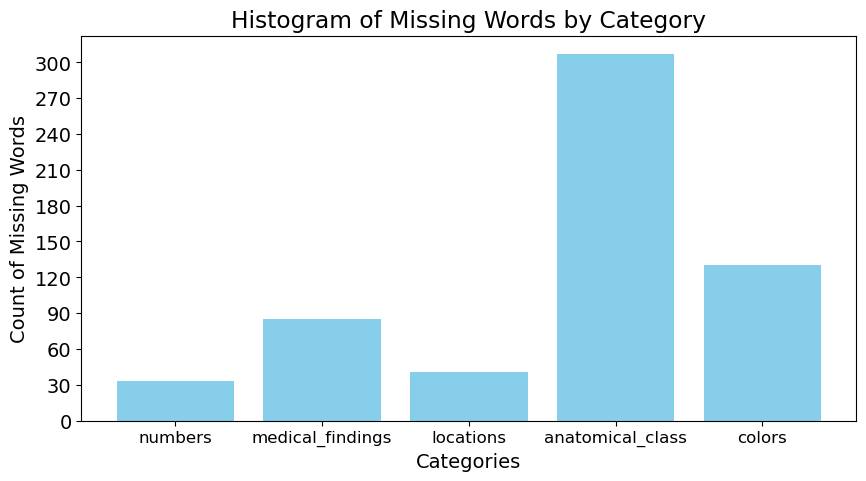

In [15]:

# Reorder categories to match the specified order
categories = ["numbers", "medical_findings", "locations", "anatomical_class", "colors"]
ordered_counts = [total_counts[cat] for cat in categories]

# Plotting the updated histogram
plt.figure(figsize=(10, 5))
plt.bar(categories, ordered_counts, color='skyblue')
plt.xlabel('Categories')
plt.ylabel('Count of Missing Words')
plt.xticks(fontsize=12)  # Adjust font size for x-axis labels

# Set y-ticks to show natural numbers with an appropriate step size
max_count = max(ordered_counts)
step_size = max(1, max_count // 10)  # Calculate step size based on the max count
plt.yticks(range(0, max_count + 1, step_size))

plt.title("Histogram of Missing Words by Category")
plt.show()
